# Object Localisatie

In deze notebook gaan we twee kernconcepten van computer vision implementeren: object localisatie en object detectie. We gebruiken hiervoor zowel zelf te trainen netwerken als pre-trained netwerken om de taken te voltooien. Object localisatie is gericht op het vinden van de positie van een enkel object in een afbeelding, terwijl object detectie het vinden van meerdere objecten met hun bijbehorende klassen omvat.
Onderstaande code-cel bevat een reeks imports en twee helper functies voor visualisatie. Deze gaan we later gebruiken voor visualisatie.

In [1]:
import os
import xml.etree.ElementTree as ET
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import kagglehub
import numpy as np

path = kagglehub.dataset_download("mbkinaci/image-localization-dataset")

# Helper Functies
def imshow(img, title=None):
    """Toont een afbeelding."""
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

def show_image_with_bbox(image, bbox, title=None):
    """Toont een afbeelding met een bounding box."""
    npimg = image.numpy() if isinstance(image, torch.Tensor) else image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    img_size = npimg.shape[1]
    xmin = bbox[0] * img_size
    ymin = bbox[1] * img_size
    xmax = bbox[2] * img_size
    ymax = bbox[3] * img_size
    print(xmin, ymin, xmax, ymax)
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                      fill=False, edgecolor='red', linewidth=2))
    if title:
        plt.title(title)
    plt.show()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.40M/5.40M [00:00<00:00, 7.55MB/s]

Extracting files...


## Oefening 1: Object Localisatie met PyTorch

In deze oefening gebruiken we PyTorch om een eenvoudig neuraal netwerk te trainen voor object localisatie. Het doel van object localisatie is om de coördinaten van de bounding box rondom een enkel object in een afbeelding te voorspellen. We maken een convolutioneel neuraal netwerk (CNN) dat leert om vier waarden te voorspellen: de x- en y-coördinaten van de bovenste linkerhoek van de bounding box, en de breedte en hoogte van de box. 

We gebruiken de dataset die hierboven is ingeladen en foto's bevat van een aantal soorten groenten.
De path variabele bevat het absolute pad naar de dataset en kan gebruikt worden om de data in te laden.
Alle data zit in een subfolder training_images en bevat twee bestanden per voorbeeld.

* Een jpg-bestand met de figuur
* Een xml-bestand met de klasse en een bounding box.

Met onderstaande figuur toon ik een figuur uit de dataset als voorbeeld hoe je aan de bestanden kan geraken.

Daarna is het de bedoeling dat je zelf een XML-dataset maakt die de jpg-bestanden en xml-bestanden inleest.
In de `__getitem__` functie moet de figuur en xml ingelezen worden. De volgende stappen moeten gebeuren in deze functie:
* lees de image in
* zet het om naar een tensor, resize het naar een figuur van 128 pixels bij 128 en normalizeer de figuur (hiervoor kunnen de volgende waarden gebruikt worden: `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`).
* Lees de xml-fgiuur in met behulp van de xml package
* Extract de 4 waarden van de bounding box en zet deze waarden om naar percentages van de breedte en hoogte. **Waarom is het omzetten naar percentages belangrijk?**
* Return de getransformeerde figuur als input en de tensor met de 4 bounding box waarden als output

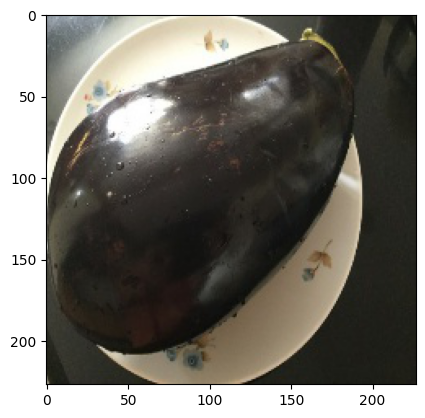

In [2]:
path = os.path.join(path, "training_images")
images=[f for f in os.listdir(path) if f.endswith(".jpg")]
plt.imshow(Image.open(os.path.join(path, images[1])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023299942..1.0000002].


tensor(31.5771) tensor(19.7357) tensor(81.7621) tensor(119.5418)


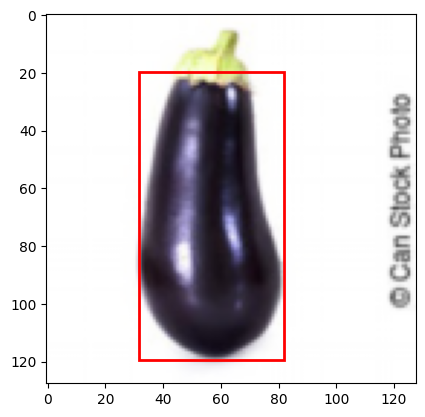

In [3]:
class XMLDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform

        # de naam van alle images ophalen
        self.images = [x for x in os.listdir(self.root_dir) if x.endswith('.jpg')]
        pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # read image
        img_path = os.path.join(self.root_dir, self.images[index])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # read xml
        xml_path = img_path[:-3] + "xml" # verander de .jpg naar .xml
        tree = ET.parse(xml_path)
        root = tree.getroot()

        width = float(root.find('size/width').text)
        height = float(root.find('size/height').text)

        bbox = root.find('object/bndbox')
        xmin = float(bbox.find('xmin').text)
        xmax = float(bbox.find('xmax').text)
        ymin = float(bbox.find('ymin').text)
        ymax = float(bbox.find('ymax').text)

        bbox = [xmin/width, ymin/height, xmax/width, ymax/height]

        return image, torch.tensor(bbox, dtype=torch.float32)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(0, 1)
])

dataset = XMLDataset(path, transform)
dataloader = DataLoader(dataset, batch_size=16)

for image, bbox in dataloader:
    show_image_with_bbox(image[5], bbox[5])
    break

In [4]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=5, out_channels=15, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=15, out_channels=25, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(), # (batch_size x 25 x width/8 x height/8)

    nn.Flatten(), # (batch_size, 25 * width/8 * height/8)

    nn.Linear(6400, 50), # eerste parameter -> 25 * width/8 * height/8 of laat het tot de flatten eens door het model gaan met een forward pass en met .shape weet je het
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(50,4) # 4 want we moeten 4 getallen voorspellen
)

inputs, targets = next(iter(dataloader))
outputs = model(inputs)
outputs.shape

torch.Size([16, 4])

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    running_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, targets) # bereken de loss
        loss.backward() # backwards propagation
        optimizer.step() # pas de gewichten aan
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch}: loss -> {running_loss/len(dataloader)}")

Epoch 0: loss -> 0.13225321502735218
Epoch 1: loss -> 0.055645556499560676
Epoch 2: loss -> 0.04136266652494669
Epoch 3: loss -> 0.036722193782528244
Epoch 4: loss -> 0.030681377199168008
Epoch 5: loss -> 0.027870567049831152
Epoch 6: loss -> 0.02221492165699601
Epoch 7: loss -> 0.024367070058360696
Epoch 8: loss -> 0.020760491024702787
Epoch 9: loss -> 0.022816205242027838
Epoch 10: loss -> 0.021654829227675993
Epoch 11: loss -> 0.020812361345936854
Epoch 12: loss -> 0.017837614752352238
Epoch 13: loss -> 0.01848705275915563
Epoch 14: loss -> 0.015024066359425584
Epoch 15: loss -> 0.01621653838083148
Epoch 16: loss -> 0.015489954268559813
Epoch 17: loss -> 0.015320437882716456
Epoch 18: loss -> 0.013995726592838764
Epoch 19: loss -> 0.013586676213890314
Epoch 20: loss -> 0.013022564894830188
Epoch 21: loss -> 0.013094563658038775
Epoch 22: loss -> 0.012586062851672372
Epoch 23: loss -> 0.0126894306546698
Epoch 24: loss -> 0.012450732135524353
Epoch 25: loss -> 0.01244888074385623
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023299942..1.0000002].


tensor(31.5771) tensor(19.7357) tensor(81.7621) tensor(119.5418)


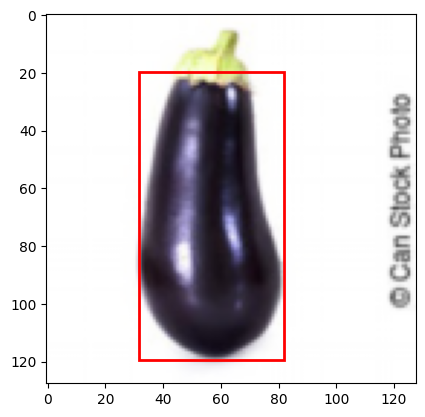

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023299942..1.0000002].


tensor(14.8872) tensor(27.3634) tensor(112.9914) tensor(102.7467)


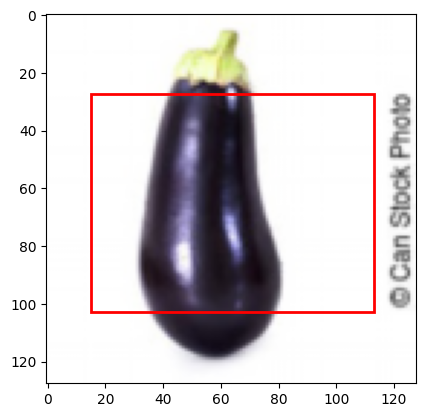

In [9]:
inputs, targets = next(iter(dataloader))
outputs = model(inputs)


show_image_with_bbox(inputs[5], targets[5])
show_image_with_bbox(inputs[5], outputs[5].detach())

## Oefening 2: Object Detectie met PyTorch

In deze oefening gebruiken we PyTorch om object detectie uit te voeren met een pre-trained Faster R-CNN-model. Faster R-CNN (Region-Based Convolutional Neural Network) is een state-of-the-art model voor object detectie dat zowel de bounding boxes als de klassen van meerdere objecten in een afbeelding kan voorspellen.

We maken gebruik van een pre-trained Faster R-CNN-model dat beschikbaar is via de `torchvision` bibliotheek. Dit model is al getraind op de COCO dataset, dus we kunnen het gebruiken om objecten in nieuwe afbeeldingen te detecteren zonder aanvullende training.

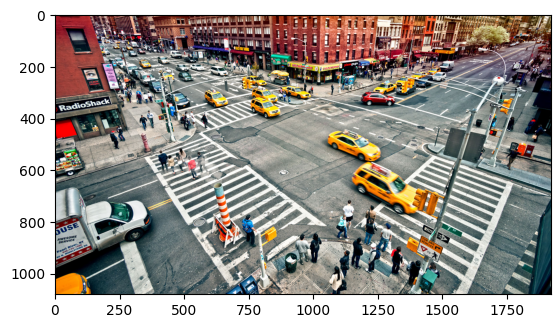

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [19]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# Define helper function to display image with bounding boxes
def show_image_with_bboxes(image, bboxes, title=None):
    """Displays an image with bounding boxes."""
    plt.imshow(F.to_pil_image(image))  # Convert tensor image to PIL image for displaying
    ax = plt.gca()  # Get the current axes instance on the current figure
    
    # Draw all bounding boxes
    for bbox in bboxes.detach():
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    if title:
        plt.title(title)
    plt.show()

# Define the transform to convert the image to a tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Load the single image
image_path = 'object-detection/img1.jpg'  # Path to your image file
image = Image.open(image_path).convert('RGB')  # Open the image file and ensure it's in RGB mode

# Apply the transformation
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension shape image (3, 1920, 1080) -> (1, 3, 1920, 1080)
 
imshow(image_tensor[0])

# load the model
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_threshold=0.7)
model.eval() # voor efficientieredenen

/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


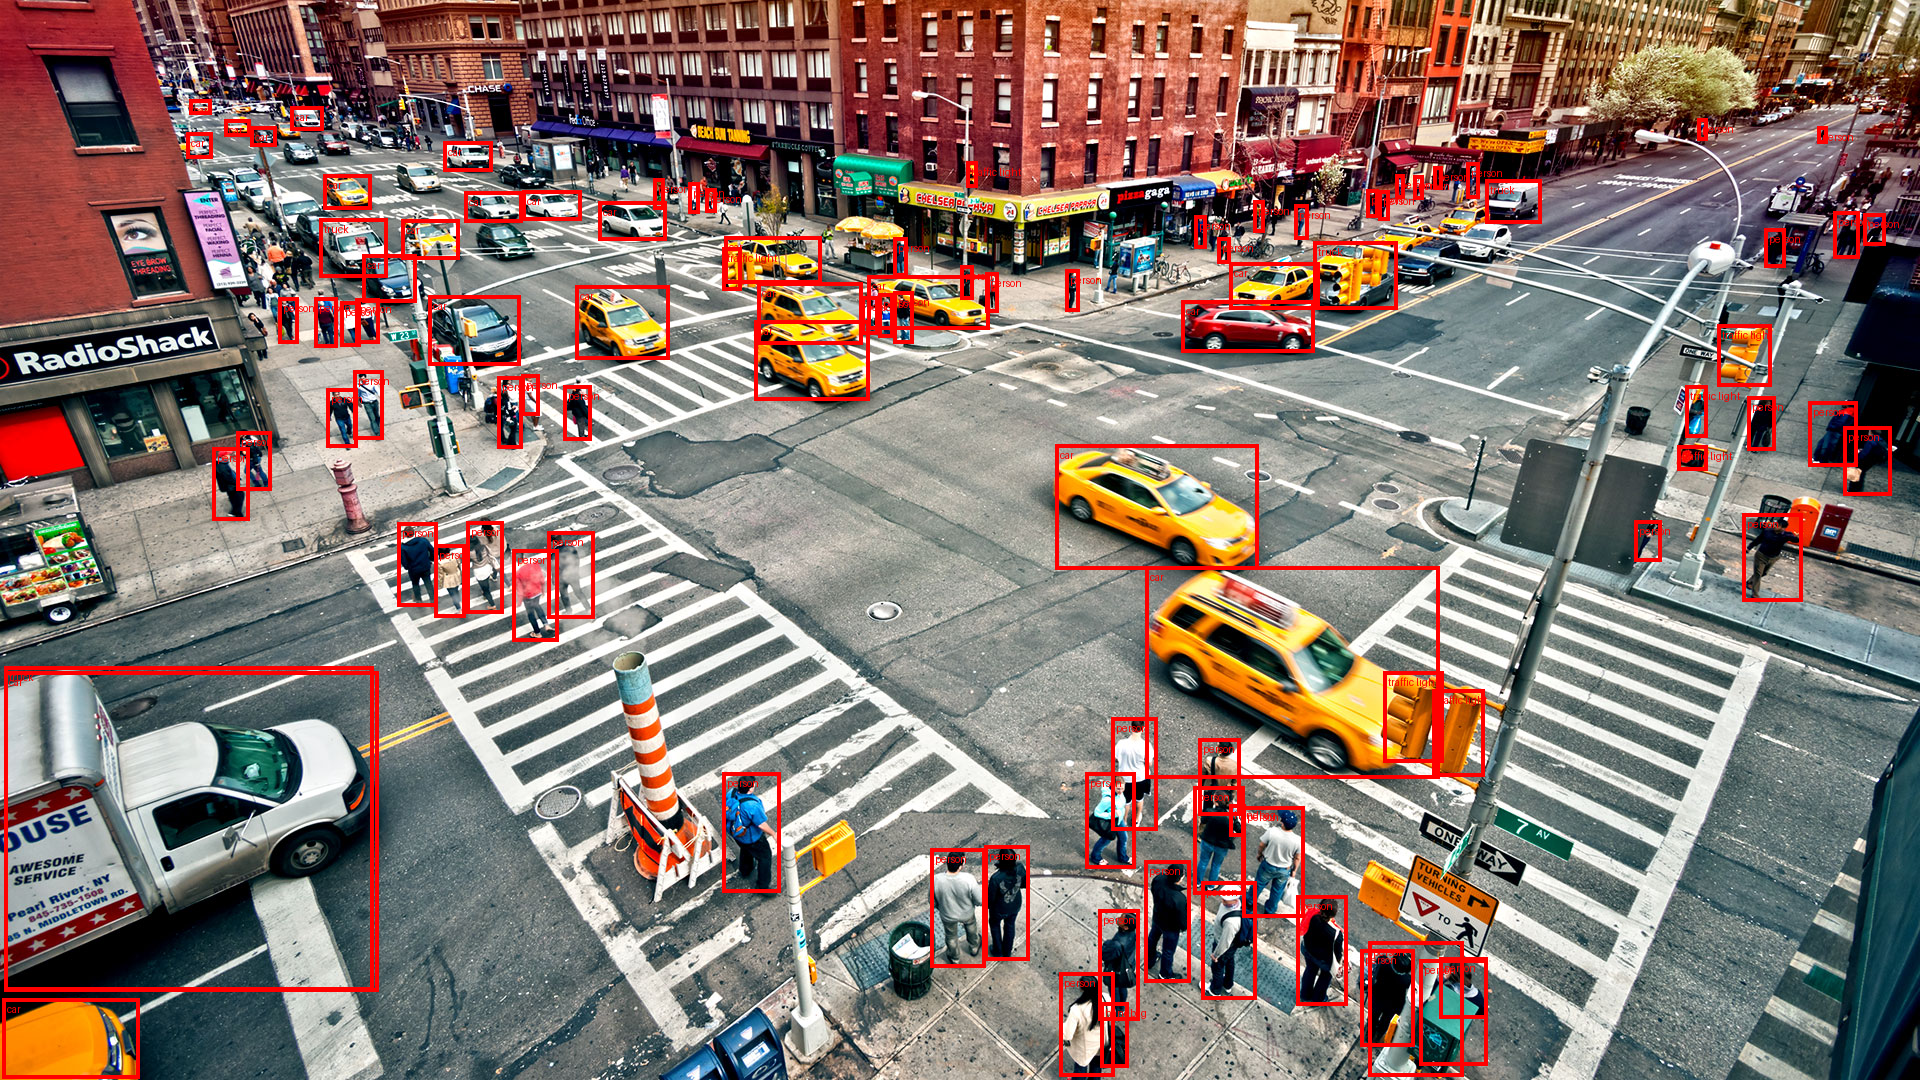

In [20]:
prediction = model(image_tensor)[0]
labels = [weights.meta['categories'][i] for i in prediction['labels']] # label idx naar naam
box = draw_bounding_boxes((image_tensor*255).type(torch.uint8)[0], boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=100)
im = to_pil_image(box.detach())
im.show()

In [21]:
prediction

{'boxes': tensor([[ 722.8554,  772.1074,  780.2344,  892.2294],
         [ 930.0281,  848.4156,  985.7040,  967.9018],
         [ 984.8943,  845.0100, 1029.4984,  960.9066],
         [1181.3856,  300.9777, 1314.0338,  352.6366],
         [1059.3372,  972.5900, 1114.6652, 1076.8673],
         [ 236.7419,  431.1284,  271.3961,  490.5491],
         [1055.0492,  444.8270, 1258.1461,  569.4573],
         [ 512.0987,  549.1786,  558.1811,  641.3824],
         [ 867.4337,  275.9908,  989.3530,  329.5394],
         [ 326.2941,  388.3802,  357.6770,  447.1966],
         [1383.1162,  671.6228, 1443.0837,  762.9255],
         [ 754.9566,  320.0180,  869.2090,  400.7762],
         [1296.7979,  895.7210, 1347.4895, 1005.0188],
         [1144.3765,  860.8336, 1190.4285,  982.6862],
         [ 598.2976,  201.6865,  666.9493,  240.7744],
         [ 757.6467,  282.2154,  862.6258,  344.5620],
         [1439.6365,  957.2802, 1487.8400, 1018.5107],
         [ 397.1696,  522.5443,  437.4736,  606.6654],
 

## Oefening 3: Object Localisatie met Keras

In deze oefening implementeren we object localisatie met Keras. Net als in Oefening 1 bouwen we een eenvoudig CNN-model dat leert om de coördinaten van een bounding box te voorspellen voor een enkel object in een afbeelding. Dit model wordt getraind op een dummy dataset met willekeurige afbeeldingen en dummy bounding box-coördinaten.

Het model bestaat uit een reeks convolutie- en poolinglagen, gevolgd door volledig verbonden lagen die de bounding box-coördinaten voorspellen. We gebruiken Mean Squared Error (MSE) als de verliesfunctie om de coördinaten te trainen.

## Oefening 4: Object detectie met model van Huggingface

Een andere bron van verscheidene AI-modellen is Huggingface.
Ga nu zelf op zoek naar een model dat gebruikt kan worden om de object detectie vraag uit oefening 2 op te lossen.
De nodige stappen om het correcte model te installeren vind je ook op de site van huggingface.

In [23]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 14.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.5/791.5 kB 12.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.9 MB/s eta 0:00:0000:0100:01


In [25]:
from transformers import DetrImageProcessor, DetrForObjectDetection

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

labels = [weights.meta['categories'][i] for i in results['labels']] # label idx naar naam
box = draw_bounding_boxes((image_tensor*255).type(torch.uint8)[0], boxes=results["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=100)
im = to_pil_image(box.detach())
im.show()

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434